In [1]:
import networkx as nx
from scipy import linalg as ln
import numpy as np
import time as tm
import matplotlib.pyplot as plt
from statistics import mean
import os
import csv
from qwak.Operator import Operator
from utils.plotTools import plot_qwak


from OperatorBenchmark2 import OperatorBenchmark2

In [2]:
n = 100
t = 1
graph = nx.cycle_graph(n)

# Time the buildDiagonalOperator method
start_time = tm.time()
op = Operator(graph)
op.buildDiagonalOperator(time = t)
end_time = tm.time()
print(f"Time taken for buildDiagonalOperator: {end_time - start_time} seconds")

# Time the buildSlowDiagonalOperator method
op2 = Operator(graph)
start_time2 = tm.time()
op2.buildExpmOperator(time = t)
end_time2 = tm.time()
print(f"Time taken for buildSlowDiagonalOperator: {end_time2 - start_time2} seconds")

Time taken for buildDiagonalOperator: 0.011992931365966797 seconds
Time taken for buildSlowDiagonalOperator: 0.16099786758422852 seconds


In [3]:
def calculate_multiple_n(start, stop, step, t, sample, filename):
    graph_sizes = []

    fast_filename = filename + "_fast_times.csv"
    slow_filename = filename + "_slow_times.csv"
    graph_sizes_filename = filename + "_graph_sizes.csv"
    sample_counter = 0
    # Check if the files already exist
    if os.path.exists(fast_filename) and os.path.exists(slow_filename) and os.path.exists(graph_sizes_filename):
        print("Files already exist. Returning graph sizes.")
        # You can read the graph sizes from the existing file if needed
        with open(graph_sizes_filename, 'r') as f:
            next(f)  # Skip the header
            for line in f:
                graph_sizes.append(int(line.strip()))
        return graph_sizes
    
    with open(fast_filename, 'w') as fast_f, open(slow_filename, 'w') as slow_f, open(graph_sizes_filename, 'w') as graph_f:
        fast_f.write("Graph Size,Sample,Fast Time\n")  # Write the header for fast times
        slow_f.write("Graph Size,Sample,Slow Time\n")  # Write the header for slow times
        graph_f.write("Graph Size\n")  # Write the header for graph sizes

        for n in range(start, stop + 1, step):
            graph = nx.cycle_graph(n)
            benchmark = OperatorBenchmark2(graph)
            # if n % 10 == 0:  # Print graph size every 10 n
            print(f'Graph size: {len(graph)}')

            for s in range(sample):
                sample_counter += 1  # Increment sample counter
                if sample_counter % 10 == 0:  # Print message every 5 samples
                    print(f'----> Sample: {sample_counter}')
                    
                # Time the buildDiagonalOperatorEig method
                start_time = tm.perf_counter()
                benchmark.buildDiagonalOperatorEig(graph, time = t)
                end_time = tm.perf_counter()
                fast_time = end_time - start_time

                # Write the data to the fast times file
                fast_f.write(f"{n},{s},{fast_time}\n")

                # Time the buildSlowDiagonalOperator method
                start_time = tm.perf_counter()
                benchmark.buildSlowDiagonalOperator(graph, time = t)
                end_time = tm.perf_counter()
                slow_time = end_time - start_time

                # Write the data to the slow times file
                slow_f.write(f"{n},{s},{slow_time}\n")
                
            sample_counter = 0
            graph_sizes.append(n)
            graph_f.write(f"{n}\n")

    return graph_sizes

def load_times_from_file(filename):
    fast_filename = filename + "_fast_times.csv"
    slow_filename = filename + "_slow_times.csv"
    graph_sizes_filename = filename + "_graph_sizes.csv"

    fast_times = {}
    slow_times = {}
    graph_sizes = []

    # Load fast times and calculate mean
    with open(fast_filename, 'r') as fast_f:
        csv_reader = csv.reader(fast_f)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            graph_size, sample, fast_time = int(row[0]), int(row[1]), float(row[2])
            if graph_size not in fast_times:
                fast_times[graph_size] = []
            fast_times[graph_size].append(fast_time)

        for size in fast_times:
            fast_times[size] = sum(fast_times[size]) / len(fast_times[size])

    # Load slow times and calculate mean
    with open(slow_filename, 'r') as slow_f:
        csv_reader = csv.reader(slow_f)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            graph_size, sample, slow_time = int(row[0]), int(row[1]), float(row[2])
            if graph_size not in slow_times:
                slow_times[graph_size] = []
            slow_times[graph_size].append(slow_time)

        for size in slow_times:
            slow_times[size] = sum(slow_times[size]) / len(slow_times[size])

    # Load graph sizes
    with open(graph_sizes_filename, 'r') as graph_f:
        csv_reader = csv.reader(graph_f)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            graph_sizes.append(int(row[0]))

    return graph_sizes, fast_times, slow_times

def plot_benchmark(graph_sizes, fast_times, slow_times):
    # print("Graph Sizes:", graph_sizes)
    # print("Fast Times:", fast_times)
    # print("Slow Times:", slow_times)

    plt.figure(figsize=(10, 6))
    fast_times_list = [fast_times[size] for size in graph_sizes]
    slow_times_list = [slow_times[size] for size in graph_sizes]
    plt.plot(graph_sizes, fast_times_list, label='buildDiagonalOperatorEig', marker='o')
    plt.plot(graph_sizes, slow_times_list, label='buildSlowDiagonalOperator', marker='x')
    plt.xlabel('Size of Graph (n)')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Benchmarking Diagonal Operators')
    plt.legend()
    plt.grid(True)
    plt.show()

start = 25
stop = 1000
step = 25
t = 50
samples = 100
filename = f'Datasets/OperatorBenchmark/Static/staticBenchmark_F{start}_T{stop}_ST{step}_TM{t}_SAMP{samples}'

# Comment this line if you want to test only the loading and plotting functions
graph_sizes = calculate_multiple_n(start, stop, step, t, samples, filename)

graph_sizes, fast_times, slow_times = load_times_from_file(filename)

Files already exist. Returning graph sizes.


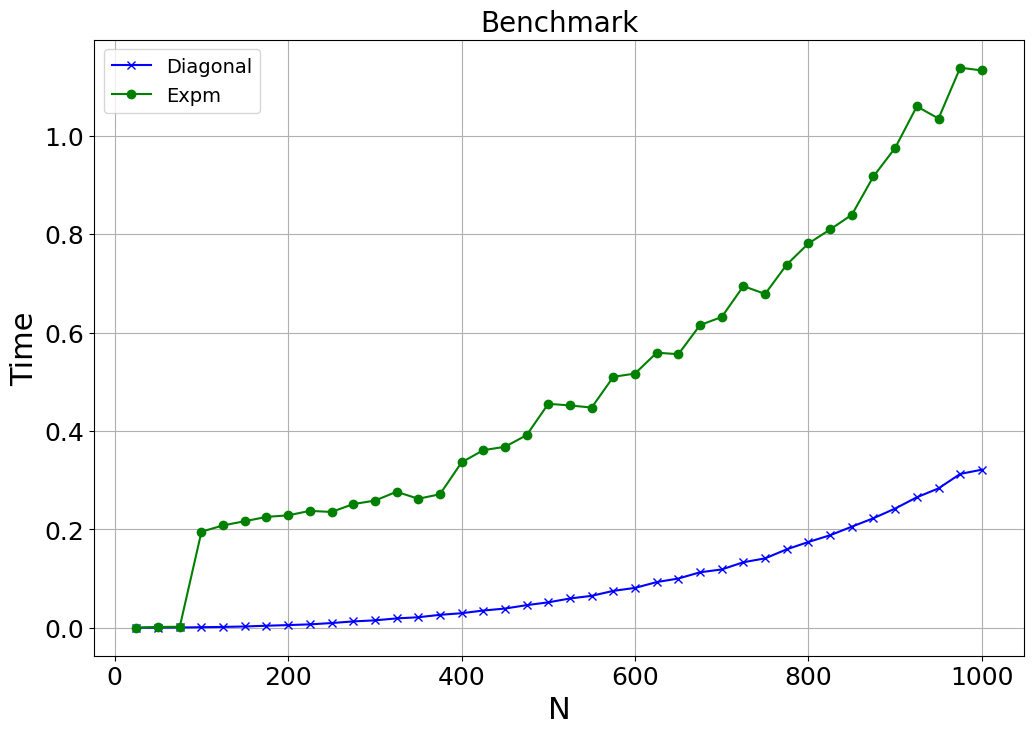

In [10]:
legend_labels = ['Diagonal', 'Expm']

params = {
    'figsize': (12, 8),
    'plot_title' : f'Benchmark',
    'x_label' : 'N',
    'y_label' : "Time",
    'legend_labels' : legend_labels,
    'legend_loc': "best",
    # 'legend_title' : 'Solutions',
    'legend_ncol' : 1,
    # 'color_list' : ['#0000FF', '#008000', '#525252'],
    'color_list' : ['b','g','r'],
    # 'line_style_list' : ['--', '-','-.' ],
    'save_path' : f'img/staticBenchmark_F{start}_T{stop}_ST{step}_TM{t}_SAMP{samples}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    'x_num_ticks' : 10,
    'y_num_ticks' : 6,
    'x_round_val' : 2,
    'y_round_val' : 3,
    # 'v_line_values' : v_line_values,
    # 'v_line_style': '--',
    'title_font_size': 20,
    'xlabel_font_size': 22,
    'ylabel_font_size': 22,
    'legend_font_size': 14,
    'legend_title_font_size': 14,
    'tick_font_size': 18,
    # 'cbar_label_font_size': 16,
    'use_grid':True,
    'marker_list': ['x', 'o']
}

fast_times_list = [fast_times[size] for size in graph_sizes]
slow_times_list = [slow_times[size] for size in graph_sizes]

y_values = [fast_times_list, slow_times_list]
x_values = [graph_sizes]*2
plot_qwak(x_value_matrix = x_values, y_value_matrix = y_values,**params)